In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import gc
import random

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import torchvision.transforms as transforms

In [2]:
# fault_file = np.load(f'dataverse_files/data/npzfiles/fault/faulttrain1.npz')
# seis_file = np.load(f'dataverse_files/data/npzfiles/seis/seistrain1.npz')
# fault_data = fault_file['arr_0.npy']
# seis_data = seis_file['arr_0.npy']
# for i in range(2, 4):
#     fault_file_new = np.load(f'dataverse_files/data/npzfiles/fault/faulttrain{i}.npz')
#     fault_data_new = fault_file['arr_0.npy']
#     fault_data = np.concatenate((fault_data, fault_data_new))
#     del fault_data_new
#     gc.collect()
#     seis_file_new = np.load(f'dataverse_files/data/npzfiles/seis/seistrain{i}.npz')
#     seis_data_new = seis_file['arr_0.npy']
#     seis_data = np.concatenate((seis_data, seis_data_new))
#     del seis_data_new
#     gc.collect()
# print(seis_data.shape)
# print(fault_data.shape)
# important_fault_data = fault_data[:, :1600, 600:]
# important_seis_data = seis_data[:, :1600, 600:]
# np.save('reduced_fault_data', important_fault_data)
# np.save('reduced_seis_data', important_seis_data)

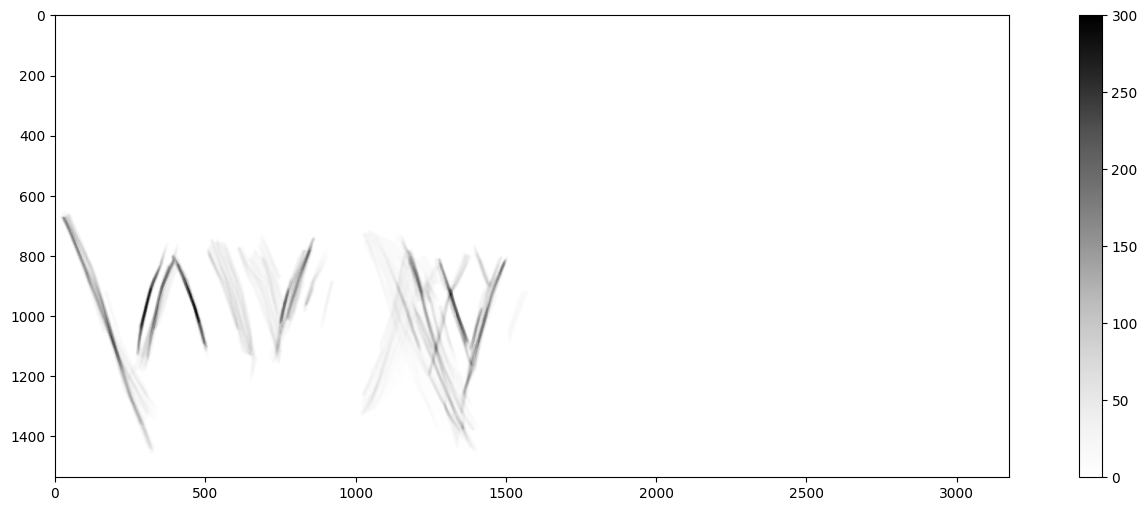

In [24]:
# plt.figure(figsize=(18,6))
# plt.imshow(fault_data.sum(axis=0).T, cmap='Greys')
# plt.colorbar()
# plt.show()

In [3]:
class SegYDataset(Dataset):
    def __init__(self, data_type=None, size_scale=1):
        self.fault_data = np.load('reduced_fault_data.npy')
        self.seis_data = np.load('reduced_seis_data.npy')
        self.size_scale = size_scale
    
    def __len__(self):
        return 100
    
    def __getitem__(self, idx):
        while True:
            size = 128
            IL, XL, Z = self.seis_data.shape
            iline = random.randint(0, IL - size)
            xline = random.randint(0, XL - size)
            zline = random.randint(0, Z - size)
            seis_slice = self.seis_data[iline: iline+size,
                                        xline: xline+size,
                                        zline: zline+size,]

            fault_slice = self.fault_data[iline: iline+size,
                                          xline: xline+size,
                                          zline: zline+size,]
            if fault_slice.sum() > 70_000:
                X = torch.Tensor(seis_slice)
                Y = torch.Tensor(fault_slice)
                return (X[None,:], Y[None, :])

In [4]:
train_dataset = SegYDataset()

In [5]:
train_loader = DataLoader(train_dataset, batch_size=1)

In [6]:
X, Y = next(iter(train_loader))

In [7]:
X.shape

torch.Size([1, 1, 128, 128, 128])

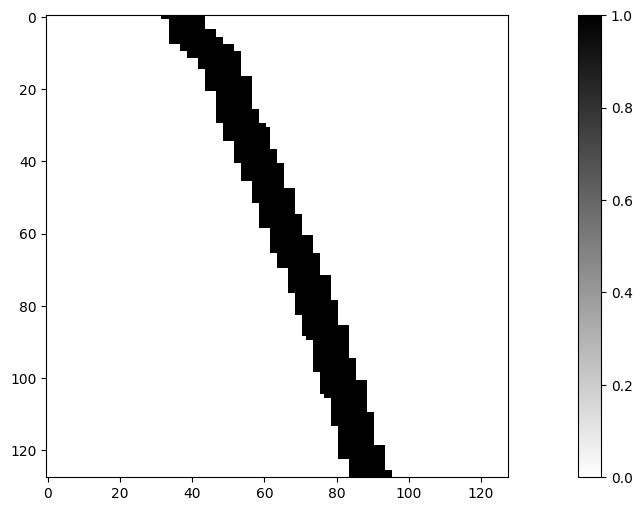

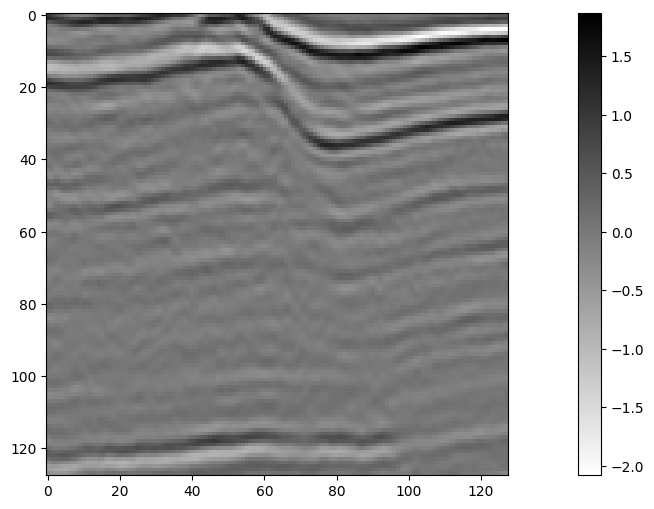

In [33]:
plt.figure(figsize=(18,6))
plt.imshow((Y[0][60].T), cmap='binary')
plt.colorbar()
plt.show()

plt.figure(figsize=(18,6))
plt.imshow(X[0][60].T, cmap='binary')
plt.colorbar()
plt.show()

In [87]:
class UNet3D(nn.Module):
    def __init__(self):
        super(UNet3D, self).__init__()
        
        self.layer_encoder_1 = nn.Sequential(nn.Conv3d(1, 32, kernel_size=5, stride=1, padding=0),
                                             nn.BatchNorm3d(32),
                                             nn.ReLU())

        self.layer_encoder_2 = nn.Sequential(nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0),
                                             nn.BatchNorm3d(64),
                                             nn.ReLU())

        self.layer_encoder_3 = nn.Sequential(nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0),
                                             nn.BatchNorm3d(64),
                                             nn.ReLU())

        self.layer_encoder_4 = nn.Sequential(nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=0),
                                             nn.BatchNorm3d(128),
                                             nn.ReLU())
        self.layer_encoder_5 = nn.Sequential(nn.Conv3d(128, 128, kernel_size=3, stride=1, padding=0),
                                             nn.BatchNorm3d(128),
                                             nn.ReLU())
        self.layer_encoder_6 = nn.Sequential(nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=0),
                                             nn.BatchNorm3d(256),
                                             nn.ReLU())
        self.layer_encoder_7 = nn.Sequential(nn.Conv3d(256, 256, kernel_size=3, stride=1, padding=0),
                                             nn.BatchNorm3d(256),
                                             nn.ReLU())
        self.layer_encoder_8 = nn.Sequential(nn.Conv3d(256, 512, kernel_size=3, stride=1, padding=0),
                                             nn.BatchNorm3d(512),
                                             nn.ReLU())
        
        self.max_pool_1 = nn.MaxPool3d(2)
        self.max_pool_2 = nn.MaxPool3d(2)
        self.max_pool_3 = nn.MaxPool3d(2)
        
        self.layer_decoder_1 = nn.Sequential(nn.ConvTranspose3d(512, 512, kernel_size=2, stride=2, padding=0, bias=False),
                                             nn.ReLU())
        self.layer_decoder_2 = nn.Sequential(nn.ConvTranspose3d(256 + 512, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                             nn.ReLU())
        self.layer_decoder_3 = nn.Sequential(nn.ConvTranspose3d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                             nn.ReLU())
        
        self.layer_decoder_4 = nn.Sequential(nn.ConvTranspose3d(256, 256, kernel_size=2, stride=2, padding=0, bias=False),
                                             nn.ReLU())
        self.layer_decoder_5 = nn.Sequential(nn.ConvTranspose3d(128 + 256, 128, kernel_size=3, stride=1, padding=1, bias=False),
                                             nn.ReLU())
        self.layer_decoder_6 = nn.Sequential(nn.ConvTranspose3d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
                                             nn.ReLU())
        
        self.layer_decoder_7 = nn.Sequential(nn.ConvTranspose3d(128, 128, kernel_size=2, stride=2, padding=0, bias=False),
                                             nn.ReLU())
        self.layer_decoder_8 = nn.Sequential(nn.ConvTranspose3d(64+128, 64, kernel_size=3, stride=1, padding=1, bias=False),
                                             nn.ReLU())
        self.layer_decoder_9 = nn.Sequential(nn.ConvTranspose3d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
                                             nn.ReLU())
        
        self.layer_decoder_10 = nn.Sequential(nn.ConvTranspose3d(64, 1, kernel_size=1, stride=1, padding=0, bias=False),
                                              nn.ReLU())
        self.layer_decoder_11 = nn.Sequential(nn.ConvTranspose3d(1, 1, kernel_size=2, stride=2, padding=0, bias=False),
                                              nn.ReLU())
    def forward(self, x):
        s0 = x.size()[2]
        s1 = x.size()[3]
        s2 = x.size()[4]
        
        first_layer_encoder = self.layer_encoder_2(self.layer_encoder_1(x))
        print(first_layer_encoder.shape)
        x = self.max_pool_1(first_layer_encoder)

        second_layer_encoder = self.layer_encoder_4(self.layer_encoder_3(x))
        x = self.max_pool_2(second_layer_encoder)

        third_layer_encoder = self.layer_encoder_6(self.layer_encoder_5(x))
        x = self.max_pool_3(third_layer_encoder)
        x = self.layer_encoder_8(self.layer_encoder_7(x))


        # ---------------------------------------------
        
        x = self.layer_decoder_1(x)


        third_layer_decoder = torch.cat((x, self.center_crop(third_layer_encoder, x.size()[2:5])),1)
        del third_layer_encoder
        x = self.layer_decoder_3(self.layer_decoder_2(third_layer_decoder))
        del third_layer_decoder


        x = self.layer_decoder_4(x)
        print(x.size())
        print(x.size()[2:5])
        second_layer_decoder = torch.cat((x, self.center_crop(second_layer_encoder, x.size()[2:5])),1)
        del second_layer_encoder

        x = self.layer_decoder_6(self.layer_decoder_5(second_layer_decoder))
        del second_layer_decoder

        x = self.layer_decoder_7(x)
        first_layer_decoder = torch.cat((x, self.center_crop(first_layer_encoder, x.size()[2:5])),1)
        del first_layer_encoder
        x = self.layer_decoder_9(self.layer_decoder_8(first_layer_decoder))

        del first_layer_decoder
        x = self.layer_decoder_10(x)
        x = self.layer_decoder_11(x)
        return x
    
    def center_crop(self, layer, target_sizes):
        batch_size, n_channels, dim1, dim2, dim3 = layer.size()
        dim1_c = (dim1 - target_sizes[0]) // 2
        dim2_c = (dim2 - target_sizes[1]) // 2
        dim3_c = (dim3 - target_sizes[2]) // 2
        return layer[:, :, dim1_c:dim1_c+target_sizes[0], dim2_c:dim2_c+target_sizes[1], dim3_c:dim3_c+target_sizes[2]]

In [88]:
model = UNet3D()

In [89]:
res = model(X)

torch.Size([1, 64, 122, 122, 122])
torch.Size([1, 256, 32, 32, 32])
torch.Size([32, 32, 32])


In [86]:
res = model(X)

torch.Size([1, 64, 120, 120, 120])


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1, 1])

In [61]:
res.shape

torch.Size([1, 1, 124, 124, 124])

In [ ]:
optim.Adam(momentu)

In [38]:
inputs = F.sigmoid(res)       

#flatten label and prediction tensors
inputs = inputs.view(-1)
targets = Y.view(-1)

D:\Otcheti\Jupyter\venv\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [40]:
smooth= 0.1
intersection = (inputs * targets).sum()                            
dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

In [43]:
torch.sigmoid(res)

tensor([[[[[0.5200, 0.5150, 0.5050,  ..., 0.5162, 0.5485, 0.5646],
           [0.5150, 0.5112, 0.5037,  ..., 0.5219, 0.5489, 0.5623],
           [0.5050, 0.5037, 0.5012,  ..., 0.5332, 0.5496, 0.5577],
           ...,
           [0.5000, 0.5000, 0.5000,  ..., 0.5273, 0.5256, 0.5248],
           [0.5000, 0.5000, 0.5000,  ..., 0.5156, 0.5257, 0.5307],
           [0.5000, 0.5000, 0.5000,  ..., 0.5098, 0.5257, 0.5336]],

          [[0.5150, 0.5112, 0.5037,  ..., 0.5200, 0.5449, 0.5572],
           [0.5112, 0.5084, 0.5028,  ..., 0.5236, 0.5442, 0.5544],
           [0.5037, 0.5028, 0.5009,  ..., 0.5309, 0.5428, 0.5488],
           ...,
           [0.5000, 0.5016, 0.5049,  ..., 0.5255, 0.5255, 0.5254],
           [0.5000, 0.5005, 0.5016,  ..., 0.5187, 0.5275, 0.5319],
           [0.5000, 0.5000, 0.5000,  ..., 0.5153, 0.5286, 0.5352]],

          [[0.5050, 0.5037, 0.5012,  ..., 0.5276, 0.5375, 0.5424],
           [0.5037, 0.5028, 0.5009,  ..., 0.5271, 0.5348, 0.5386],
           [0.5012, 0.5009

In [46]:
torch.binary_cross_entropy_with_logits(res, Y)

tensor([[[[[0.7339, 0.7236, 0.7032,  ..., 0.7261, 0.7953, 0.8314],
           [0.7236, 0.7159, 0.7007,  ..., 0.7379, 0.7960, 0.8262],
           [0.7032, 0.7007, 0.6957,  ..., 0.7619, 0.7976, 0.8158],
           ...,
           [0.6931, 0.6931, 0.6931,  ..., 0.7492, 0.7458, 0.7441],
           [0.6931, 0.6931, 0.6931,  ..., 0.7249, 0.7458, 0.7565],
           [0.6931, 0.6931, 0.6931,  ..., 0.7129, 0.7459, 0.7627]],

          [[0.7236, 0.7159, 0.7007,  ..., 0.7340, 0.7871, 0.8146],
           [0.7159, 0.7102, 0.6988,  ..., 0.7416, 0.7857, 0.8083],
           [0.7007, 0.6988, 0.6950,  ..., 0.7569, 0.7827, 0.7959],
           ...,
           [0.6931, 0.6964, 0.7030,  ..., 0.7455, 0.7454, 0.7453],
           [0.6931, 0.6942, 0.6964,  ..., 0.7313, 0.7498, 0.7592],
           [0.6931, 0.6931, 0.6931,  ..., 0.7243, 0.7520, 0.7661]],

          [[0.7032, 0.7007, 0.6957,  ..., 0.7499, 0.7710, 0.7817],
           [0.7007, 0.6988, 0.6950,  ..., 0.7489, 0.7652, 0.7734],
           [0.6957, 0.6950